Notes to try: Feature importance; conversion of data to 0 and 1; logistic regression threshold

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import  cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve,log_loss, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import itertools


In [3]:
dfraw = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/Sams_github/Capstones/Capstone2/Capstone_2_project/patient.csv')

In [4]:
dfraw.shape

(95839, 20)

In [5]:
pd.set_option("display.max_rows", 101)

In [6]:
dfraw.head(3)

,sex,patient_type,intubated,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,another_case,outcome,icu,death_date
0,2,1,97,2,42,97,2,2,1,2,2,2,2,2,2,2,99,1,97,9999-99-99
1,1,1,97,2,51,2,2,2,2,2,2,2,2,2,2,2,99,1,97,9999-99-99
2,2,2,2,2,51,97,1,2,2,2,1,2,2,1,2,2,99,1,2,9999-99-99


In [7]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95839 entries, 0 to 95838
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   sex                     95839 non-null  int64 
 1   patient_type            95839 non-null  int64 
 2   intubated               95839 non-null  int64 
 3   pneumonia               95839 non-null  int64 
 4   age                     95839 non-null  int64 
 5   pregnant                95839 non-null  int64 
 6   diabetes                95839 non-null  int64 
 7   copd                    95839 non-null  int64 
 8   asthma                  95839 non-null  int64 
 9   immunosuppression       95839 non-null  int64 
 10  hypertension            95839 non-null  int64 
 11  other_diseases          95839 non-null  int64 
 12  cardiovascular          95839 non-null  int64 
 13  obesity                 95839 non-null  int64 
 14  chronic_kidney_failure  95839 non-null  int64 
 15  sm

In [8]:
dfraw.columns

Index(['sex', 'patient_type', 'intubated', 'pneumonia', 'age', 'pregnant',
       'diabetes', 'copd', 'asthma', 'immunosuppression', 'hypertension',
       'other_diseases', 'cardiovascular', 'obesity', 'chronic_kidney_failure',
       'smoker', 'another_case', 'outcome', 'icu', 'death_date'],
      dtype='object')

# Data cleaning

In [9]:
# DO NOT ALTER THESE LISTS!!!!!

# Select out continous variable in seperate list
unaltercols = ['age','outcome']
# Select all columns that  will be treated the same way
altercols = ['sex', 'patient_type', 'intubated', 'pneumonia',  'pregnant',
       'diabetes', 'copd', 'asthma', 'immunosuppression', 'hypertension',
       'other_diseases', 'cardiovascular', 'obesity', 'chronic_kidney_failure',
       'smoker', 'icu']

# Eliminate unclears (98 values), clear nulls (99)  and convert non-applicable (97) to 'no' for all columns
# except pregnant or icu columns.
# This will allow more choice downstream.
dfreplace = pd.concat([dfraw[unaltercols], dfraw[altercols].replace({99:np.nan, 97:2, 98:np.nan})], axis = 1)

# Further eliminate nulls from pregnant column
#dfreplace1 = pd.concat([dfreplace,dfraw['pregnant'].replace(98,np.nan)], axis = 1)                    

# Further eliminate nulls from icu column
#dfreplace2 = pd.concat([dfreplace, dfraw['icu'].replace(99, np.nan)],axis=1)
dfreplace2 = dfreplace.loc[dfreplace['patient_type'] == 2,:]
dfreplace2 = pd.get_dummies(dfreplace2, columns = ['outcome']).drop('patient_type', axis = 1)
dfreplace2.columns

Index(['age', 'sex', 'intubated', 'pneumonia', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker', 'icu',
       'outcome_1', 'outcome_2', 'outcome_3'],
      dtype='object')

In [10]:
dfreplace2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25571 entries, 2 to 95836
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     25571 non-null  int64  
 1   sex                     25571 non-null  float64
 2   intubated               25547 non-null  float64
 3   pneumonia               25571 non-null  float64
 4   pregnant                25521 non-null  float64
 5   diabetes                25386 non-null  float64
 6   copd                    25397 non-null  float64
 7   asthma                  25391 non-null  float64
 8   immunosuppression       25377 non-null  float64
 9   hypertension            25397 non-null  float64
 10  other_diseases          25289 non-null  float64
 11  cardiovascular          25382 non-null  float64
 12  obesity                 25394 non-null  float64
 13  chronic_kidney_failure  25391 non-null  float64
 14  smoker                  25392 non-null

# Feature engineering

In [11]:
# In case pregnancy is as feature, the following code builds two dataframes to choose from: dfpreg or dfall 
target = 'intubated'
class_balance = 'yes'


dfpreg = dfreplace2.loc[(dfreplace2['age']>=dfreplace2.loc[dfreplace2['pregnant']==1]['age'].min()) & (dfreplace2['age']<=dfreplace2.loc[dfreplace2['pregnant']==1]['age'].max()) & (dfreplace2['sex'] == 1)]
if 'sex' in dfpreg: dfpreg = dfpreg.drop('sex', axis = 1).drop('icu', axis = 1)

dficu = dfreplace2.loc[(dfreplace2['icu']==1)].drop('icu', axis = 1)

dfall = dfreplace2.copy().drop('icu', axis = 1)

custom_feat_cols = ['age', 'pneumonia', 'immunosuppression', 'other_diseases', 'obesity',
       'outcome_1', 'outcome_2']





  

dfdropcols = [x for x in dfall if x != target and x not in custom_feat_cols]

dfdropcols

['sex',
 'pregnant',
 'diabetes',
 'copd',
 'asthma',
 'hypertension',
 'cardiovascular',
 'chronic_kidney_failure',
 'smoker',
 'outcome_3']

In [12]:

dfpregdrop= pd.concat([dfall['sex'], dfpreg], axis = 1).drop(dfdropcols, axis = 1)
dfalldrop= dfall.drop(dfdropcols, axis = 1)
dficudrop= pd.concat([dficu], axis = 1).drop(dfdropcols, axis = 1)

# Choose df here:

df = dficudrop



In [13]:
if target == 'icu': 
  df['icu'] = dfreplace2['icu']
  if 'intubated' in df:
    df = df.drop('intubated', axis = 1)

In [14]:
#Convert all 2s to 0 as they represent 'no' and 1 represents yes, except age, if in columns

if 'age' in df:
    columns_for_conversion = df.columns.tolist()
    columns_for_conversion.remove('age')
    df[columns_for_conversion] = df.loc[:,columns_for_conversion].replace(2,0)
else:
    df.replace(2,0, inplace=True)
    



In [15]:
# Deleting leftover nulls from conversion of 99 and 98 to NaN
df_non_nulls = df.dropna()

# Checking nulls have been eliminated
df_non_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 18 to 95824
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2127 non-null   int64  
 1   intubated          2127 non-null   float64
 2   pneumonia          2127 non-null   float64
 3   immunosuppression  2127 non-null   float64
 4   other_diseases     2127 non-null   float64
 5   obesity            2127 non-null   float64
 6   outcome_1          2127 non-null   uint8  
 7   outcome_2          2127 non-null   uint8  
dtypes: float64(5), int64(1), uint8(2)
memory usage: 120.5 KB


In [16]:
# Investigate cross-feature correlations to eliminate multicolinearity
df_non_nulls.corr()

,age,intubated,pneumonia,immunosuppression,other_diseases,obesity,outcome_1,outcome_2
age,1.000000,0.074865,0.144601,-0.080505,-0.059744,0.086224,0.212248,-0.221036
intubated,0.074865,1.000000,0.242915,-0.041955,-0.050374,0.058181,0.141628,-0.117195
pneumonia,0.144601,0.242915,1.000000,-0.020579,-0.026533,0.053071,0.128167,-0.153664
immunosuppression,-0.080505,-0.041955,-0.020579,1.000000,0.222673,-0.014880,-0.134185,0.135765
other_diseases,-0.059744,-0.050374,-0.026533,0.222673,1.000000,-0.022621,-0.121600,0.131174
obesity,0.086224,0.058181,0.053071,-0.014880,-0.022621,1.000000,0.089727,-0.101076
outcome_1,0.212248,0.141628,0.128167,-0.134185,-0.121600,0.089727,1.000000,-0.814053
outcome_2,-0.221036,-0.117195,-0.153664,0.135765,0.131174,-0.101076,-0.814053,1.000000


In [17]:
# Seperate features and target for modeling
X = df_non_nulls.drop(target, axis=1)
y = df_non_nulls[target]

In [18]:
X.shape

(2127, 7)

In [19]:
k = 7
if len(X.columns) >= k:
    skb = SelectKBest(k = k, score_func = f_classif)
    best_kfit = skb.fit(X, y)
    X_best_feat = best_kfit.fit_transform(X,y)

    X_best_feat = pd.DataFrame(X_best_feat, columns=X.columns[best_kfit.get_support()])

    print(X_best_feat.columns)
else:
    pass

Index(['age', 'pneumonia', 'immunosuppression', 'other_diseases', 'obesity',
       'outcome_1', 'outcome_2'],
      dtype='object')


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
if class_balance == 'yes':
    from sklearn.utils import resample
    X1 = pd.concat([X_train,y_train], axis=1)

    not_target = X1[X1[target]==0]
    targetsam = X1[X1[target]==1]
    upsample_target = resample(targetsam,replace=True, n_samples=len(not_target))
    upsampled = pd.concat([not_target, upsample_target])
    y_train = upsampled[target]
    X_train = upsampled.drop(target, axis=1)
else:
    pass

In [22]:
print(len(X_train), len(y_train))

1844 1844


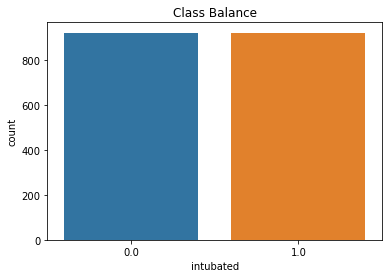

In [23]:
sns.countplot(y_train)
plt.title('Class Balance')
plt.show()


# Logistic Regressions

Class imbalance will pose a problem for predicting instances of the less frequent category e.g intubated

{'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best threshold for test macro average recall score for intubated is  0.43


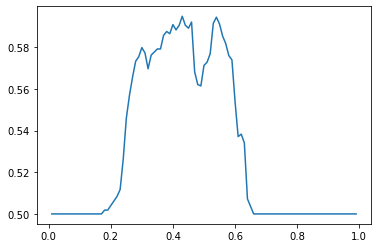

In [24]:
lr1 = LogisticRegression()
thresholds = [x for x in np.arange(.01,1,.01)]
c_values = [10**x for x in range(-3,2)]
params = {'solver':['liblinear','lbfgs'], 'C':c_values, 'penalty':['l2'], 'max_iter': [10000]}

gslr1 = GridSearchCV(lr1, params)
gslr1.fit(X_train, y_train)


print(gslr1.best_params_)
    
y_test_predlr1 = gslr1.predict(X_test)
y_train_predlr1 = gslr1.predict(X_train)


y_train_probs = gslr1.predict_proba(X_train)
y_test_probs = gslr1.predict_proba(X_test)

test_intubation_scores = []
train_intubation_scores = []
y_pred_test_thresh = []
y_pred_train_thresh = []
for i in thresholds:
    
    y_pred_test_thresh = [1 if x[1] >= i else 0 for x in y_test_probs]
    test_intubation_scores.append(recall_score(y_test, y_pred_test_thresh, average = 'macro'))
    
    y_pred_train_thresh = [1 if x[1] >= i else 0 for x in y_train_probs]
    train_intubation_scores.append(recall_score(y_train, y_pred_train_thresh, average = 'macro'))

best_test_thresh = thresholds[test_intubation_scores.index(max(test_intubation_scores))]
best_train_thresh = thresholds[train_intubation_scores.index(max(train_intubation_scores))]

y_pred_test = [1 if x[1] >= best_test_thresh else 0 for x in y_test_probs]   
y_pred_train = [1 if x[1] >= best_train_thresh else 0 for x in y_train_probs]

sns.lineplot(thresholds, test_intubation_scores)


print(f'Best threshold for test macro average recall score for {target} is ', best_test_thresh)



In [25]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=20)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=20)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
print('LR1 confusion matrix')
lr1train = confusion_matrix(y_train, y_pred_train, normalize= None)
lr1test = confusion_matrix(y_test, y_pred_test, normalize = None)


LR1 confusion matrix


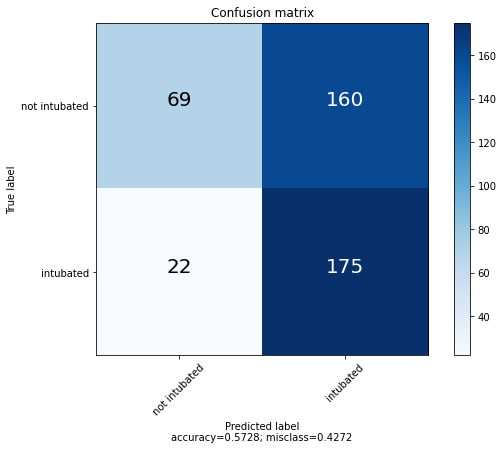

In [27]:
target_names = ['not '+target, target]
plot_confusion_matrix(lr1test,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None)

In [28]:
print('Test macro average recall score is ',recall_score(y_test, y_pred_test, average = 'macro'))
print('Train macro average recall score is ', recall_score(y_train, y_pred_train,average = 'macro'))

Test macro average recall score is  0.5948174583822845
Train macro average recall score is  0.618763557483731


In [29]:
                                         
lr1best = LogisticRegression(**gslr1.best_params_)
lr1best.fit(X_train, y_train)
abs_coefs = np.abs(lr1best.coef_[0])
coefs = pd.DataFrame(abs_coefs, index=X_train.columns, columns=['Coef'])
coefs.loc['INTERCEPT'] = [lr1best.intercept_[0]]
coefs.sort_values('Coef', ascending=False)


,Coef
pneumonia,1.075430
outcome_1,0.322743
other_diseases,0.309758
outcome_2,0.186030
obesity,0.135106
immunosuppression,0.110170
age,0.004065
INTERCEPT,-0.764909


# Random Forests

In [30]:

rf1 = RandomForestClassifier(max_depth=3,  max_features=4,  n_estimators=10000)
rf1.fit(X_train, y_train)

y_test_predrf1 = rf1.predict(X_test)
y_train_predrf1 = rf1.predict(X_train)
print('Test macro average recall score is ', recall_score(y_test, y_test_predrf1, average = 'macro'))
print('Train macro average recall score is ', recall_score(y_train, y_train_predrf1,average = 'macro'))


Test macro average recall score is  0.580087779575732
Train macro average recall score is  0.6393709327548807


In [31]:
print('RF1 confusion matrix')
print('Training\n', confusion_matrix(y_train, y_train_predrf1, normalize= None))
print('Test\n', confusion_matrix(y_test, y_test_predrf1, normalize = None))

RF1 confusion matrix
Training
 [[560 362]
 [303 619]]
Test
 [[132  97]
 [ 82 115]]


# K Nearest Neighbors

In [32]:

knn1 = KNeighborsClassifier(n_neighbors=6, weights='uniform', leaf_size=20)
knn1.fit(X_train, y_train)

y_test_predknn1 = knn1.predict(X_test)
y_train_predknn1 = knn1.predict(X_train)
print('Test macro average recall score is ',recall_score(y_test, y_test_predknn1,average = 'macro'))
print('Train macro average recall score is ',recall_score(y_train, y_train_predknn1,average = 'macro'))


Test macro average recall score is  0.5585308004344646
Train macro average recall score is  0.7001084598698482


In [33]:

print(f'KNN1 cv scores are {cross_val_score(knn1, X_train, y_train, cv= 5)}')



KNN1 cv scores are [0.60162602 0.57723577 0.58536585 0.59620596 0.5951087 ]


In [34]:
print('knn1 confusion matrix')
print('Training\n', confusion_matrix(y_train, y_train_predknn1, normalize= None))
print('Test\n', confusion_matrix(y_test, y_test_predknn1, normalize = None))

knn1 confusion matrix
Training
 [[699 223]
 [330 592]]
Test
 [[157  72]
 [112  85]]


# Support Vector Classification

In [35]:
c_values = [10**x for x in range(-2, 0)]
svmlin = SVC()
parameters = {'kernel':['linear'], 'C':c_values}
svmgrid = GridSearchCV(svmlin, parameters)
svmgrid.fit(X_train, y_train)

y_train_predsvmgrid = svmgrid.predict(X_train)
y_test_predsvmgrid = svmgrid.predict(X_test)

print('Test macro average recall score is ', recall_score(y_test, y_test_predsvmgrid,average = 'macro'))
print('Train macro average recall score is ', recall_score(y_train, y_train_predsvmgrid,average = 'macro'))
print(svmgrid.best_params_)


Test macro average recall score is  0.5882672400416731
Train macro average recall score is  0.5932754880694143
{'C': 0.1, 'kernel': 'linear'}


In [36]:

print('svmrbf confusion matrix')
print('Training\n', confusion_matrix(y_train, y_train_predsvmgrid, normalize= None))
print('Test\n', confusion_matrix(y_test,y_test_predsvmgrid, normalize = None))


svmrbf confusion matrix
Training
 [[250 672]
 [ 78 844]]
Test
 [[ 66 163]
 [ 22 175]]


In [37]:
print(f'SVMlin cv scores are {cross_val_score(svmlin, X, y, cv= 5)}')

SVMlin cv scores are [0.54225352 0.52816901 0.54117647 0.53411765 0.55529412]
